# Drone Flights Analysis

## Introduction

Zipline operates the world’s only drone delivery system at national scale to send urgent medicines like blood transfusions and vaccines to those in need – no matter where they live. Zipline is at the forefront of a logistics revolution, designing, manufacturing, and operating our own battery powered autonomous aircraft fleet to overcome the challenges of delivering just-in-time, lifesaving medical supplies around the world.

A drone is known internally as Zip. A Zip is made up of three components — a battery, wing, and body. For each flight, a flight operator selects one of each component, "asembling" the Zip immediately prior to flight, as our fulfillment operators prepare the package before it's placed in the assembled Zip.

This example dataset is taken from Zipline's distribution center in Muhanga which contains information of drones used to serve rural hospitals in the western half of Rwanda, delivering blood transfusions used to treat conditions like malaria anemia and postpartum hemorrhaging. After an order is placed, an electromechanically actuated launcher accelerates Zip at 5 g's from 0 to 30 m/s (67 mph) in less than a second. From there, the Zip autonomously navigates a pre-defined route to the delivery site, drops its package, and returns to the distribution center to recover.

The dataset contains informations of various drone flights in the form of excel csv files. Each file contains the following signals from 5 seconds prior to launch, to 15 seconds after launch, logged at approximately 50Hz:

- seconds_since_launch(seconds) -	time since launch
- position_ned_m[0]   (meters) -	position of the zip relative to a fixed reference point in the north direction
- position_ned_m[1]	(meters) - position of the zip relative to a fixed reference point in the east direction
- position_ned_m[2]	(meters)	position of the zip relative to a fixed reference point in the down direction
- velocity_ned_mps[0]	(meters/second)	- velocity of the zip, in the north direction
- velocity_ned_mps[1]	(meters/second)	- velocity of the zip, in the east direction
- velocity_ned_mps[2]	(meters/second)	- velocity of the zip, in the down direction
- accel_body_mps2[0]	(meters/second^2) - acceleration of the zip, in the body-forward direction
- accel_body_mps2[1]	(meters/second^2) - acceleration of the zip, in the body-right direction
- accel_body_mps2[2]	(meters/second^2) - acceleration of the zip, in the body-down direction
- orientation_rad[0]	(radians) - Euler (Tait-Bryan) roll of the zip
- orientation_rad[1]	(radians) - Euler (Tait-Bryan) pitch of the zip
- orientation_rad[2]	(radians) - Euler (Tait-Bryan) yaw of the zip
- angular_rate_body_radps[0]	(radians/second) - Angular velocity of the zip, about the body-forward direction
- angular_rate_body_radps[1]	(radians/second) - Angular velocity of the zip, about the body-right direction
- angular_rate_body_radps[2]	(radians/second) - Angular velocity of the zip, about the body-down direction
- position_sigma_ned_m[0]	(meters) - estimated standard error of position_ned_m[0], i.e. positional uncertainty in the north direction
- position_sigma_ned_m[1]	(meters) - estimated standard error of position_ned_m[1], i.e. positional uncertainty in the east direction
- position_sigma_ned_m[2]	(meters) - estimated standard error of position_ned_m[2], i.e. positional uncertainty in the down direction

There is also a summary file which contains the following data for each flight in the dataset:

- flight_id - unique identifier for the flight
- battery_serial_number - serial number of the battery
- body_serial_number - serial number of the body
- wing_serial_number - serial number of the wing
- commit - git commit SHA representing the version of software
- launch_airspeed (meters/second) - airspeed of the plane during launch
- launch_groundspeed (meters/second) - groundspeed of the plane during launch
- launch_timestamp - time string YYYT-MM-DD HH:MM:SS CAT where CAT, i.e. Central Africa Time, is the timezone
- preflight_voltage (volts) -dc voltage of the battery immediately prior to launch
- air_temperature (celsius) - air temperature during launch
- rel_humidity (percentage) - relative humidity during launch
- static_pressure (pascals) - static air pressure during launch
- wind_direction (degrees) - direction of the wind during launch, with 0 blowing to the north, 90 blowing to the east
- wind_magnitude (meters/second) - magnitude of the wind during launch

**Objective**: The objective of this project is to perform independent exploratory data analysis & visualization of drone flights data in order to find hidden trends, patterns, and anomalies.

## Importing Data and Required Libraries

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean #to find euclidean distance between points
from fastdtw import fastdtw #to find DTW distance
from scipy.cluster.hierarchy import ward, dendrogram, fcluster #for hierarchical clustering

import scipy
import sklearn
import glob
import re
import math
import warnings
warnings.filterwarnings("ignore")

Getting paths of all files

In [2]:
drone_files = glob.glob('C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\flight*.csv')

In [3]:
drone_files[0:5]

['C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\flight_16951.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\flight_16952.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\flight_16954.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\flight_16955.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\flight_16957.csv']

Combining all files and making a single dataframe

In [4]:
df = pd.DataFrame()

for i in drone_files:
    df0 = pd.read_csv(i)
    df0["flight_No"] = int(re.findall(r'\d+', i)[0])
    df = pd.concat([df, df0])

df = df.reset_index(drop = True)

In [5]:
df.head(10)

,seconds_since_launch,position_ned_m[0],position_ned_m[1],position_ned_m[2],velocity_ned_mps[0],velocity_ned_mps[1],velocity_ned_mps[2],accel_body_mps2[0],accel_body_mps2[1],accel_body_mps2[2],orientation_rad[0],orientation_rad[1],orientation_rad[2],angular_rate_body_radps[0],angular_rate_body_radps[1],angular_rate_body_radps[2],position_sigma_ned_m[0],position_sigma_ned_m[1],position_sigma_ned_m[2],flight_No
0,-4.99846,5.143372,8.170100,-4.561916,0.0,0.0,0.0,2.200169,-0.059350,-9.497843,0.007623,0.214396,2.741056,0.002011,-0.000639,0.000495,0.186535,0.340824,0.428683,16951
1,-4.97846,5.143372,8.170100,-4.561916,0.0,0.0,0.0,2.027999,-0.053380,-9.611131,0.007616,0.214414,2.741054,0.004984,-0.000766,0.001946,0.186535,0.340824,0.428683,16951
2,-4.95833,5.143372,8.170100,-4.561916,0.0,0.0,0.0,2.051773,-0.264372,-9.632382,0.007602,0.214424,2.741051,0.000886,0.002613,-0.000127,0.186535,0.340824,0.428683,16951
3,-4.93848,5.143549,8.168812,-4.561501,0.0,0.0,0.0,2.173164,-0.113283,-9.657514,0.007609,0.214409,2.741053,-0.001839,-0.001339,-0.000740,0.186556,0.340836,0.428738,16951
4,-4.91848,5.143549,8.168812,-4.561501,0.0,0.0,0.0,2.012778,-0.045159,-9.635982,0.007615,0.214412,2.741054,0.000497,-0.000715,0.001186,0.186556,0.340836,0.428738,16951
5,-4.89849,5.143012,8.170419,-4.563326,0.0,0.0,0.0,2.077366,-0.070073,-9.526079,0.007610,0.214417,2.741053,0.000475,0.001337,0.000074,0.186575,0.340849,0.428794,16951
6,-4.87850,5.143012,8.170419,-4.563326,0.0,0.0,0.0,2.168130,-0.001093,-9.594013,0.007615,0.214402,2.741054,0.000139,-0.002073,-0.000767,0.186575,0.340849,0.428794,16951
7,-4.85848,5.143012,8.170419,-4.563326,0.0,0.0,0.0,1.938173,-0.068898,-9.672871,0.007622,0.214410,2.741055,0.001792,0.000848,0.000303,0.186575,0.340849,0.428794,16951
8,-4.83851,5.143236,8.170900,-4.565207,0.0,0.0,0.0,2.158677,-0.156225,-9.559793,0.007614,0.214424,2.741054,-0.001104,0.002537,-0.001246,0.186595,0.340861,0.428849,16951
9,-4.81852,5.143236,8.170900,-4.565207,0.0,0.0,0.0,2.115438,-0.032763,-9.527992,0.007606,0.214389,2.741052,-0.000456,-0.002244,0.002054,0.186595,0.340861,0.428849,16951


In [6]:
df.tail(10)

,seconds_since_launch,position_ned_m[0],position_ned_m[1],position_ned_m[2],velocity_ned_mps[0],velocity_ned_mps[1],velocity_ned_mps[2],accel_body_mps2[0],accel_body_mps2[1],accel_body_mps2[2],orientation_rad[0],orientation_rad[1],orientation_rad[2],angular_rate_body_radps[0],angular_rate_body_radps[1],angular_rate_body_radps[2],position_sigma_ned_m[0],position_sigma_ned_m[1],position_sigma_ned_m[2],flight_No
447266,14.81540,-390.11520,179.39098,-77.028990,-24.906546,13.969920,-2.192134,1.513031,-0.149371,-4.787801,-0.292426,0.055943,2.524530,-0.098204,-0.113149,-0.093117,0.421860,0.461620,0.441521,17745
447267,14.83539,-390.61462,179.66829,-77.070800,-24.909270,14.011065,-2.081894,1.532638,-0.134902,-4.845049,-0.294624,0.053455,2.523389,-0.116818,-0.109564,-0.092526,0.421569,0.461461,0.441532,17745
447268,14.85539,-391.11127,179.94803,-77.122470,-24.911629,14.049208,-1.980746,1.452728,-0.080848,-4.864408,-0.297068,0.050946,2.522257,-0.119657,-0.104186,-0.090981,0.421515,0.461406,0.437942,17745
447269,14.87538,-391.60860,180.22937,-77.154670,-24.913513,14.090552,-1.880552,1.522432,-0.168869,-4.953877,-0.299476,0.048544,2.521171,-0.118038,-0.098934,-0.086838,0.421515,0.461406,0.437942,17745
447270,14.89537,-392.10825,180.50981,-77.190180,-24.910635,14.133635,-1.779945,1.445222,-0.141950,-5.173072,-0.301779,0.046170,2.520025,-0.129886,-0.098182,-0.084601,0.421221,0.461243,0.441551,17745
447271,14.91537,-392.60535,180.79272,-77.224780,-24.911470,14.174516,-1.687460,1.469600,-0.037233,-5.332757,-0.304555,0.043933,2.518995,-0.136976,-0.091683,-0.082132,0.421221,0.461243,0.441551,17745
447272,14.93536,-393.10406,181.07443,-77.256660,-24.910990,14.218034,-1.593212,1.505286,-0.016975,-5.504356,-0.306934,0.041837,2.517895,-0.129828,-0.087184,-0.082062,0.420927,0.461076,0.441563,17745
447273,14.95541,-393.60312,181.35971,-77.288410,-24.909925,14.261593,-1.505272,1.450159,-0.101216,-5.621824,-0.309482,0.039781,2.516902,-0.125186,-0.082832,-0.078339,0.420871,0.461021,0.437973,17745
447274,14.97536,-394.09906,181.64468,-77.316900,-24.910542,14.304694,-1.417572,1.509049,-0.007444,-5.587275,-0.312063,0.037750,2.515962,-0.128195,-0.082847,-0.075472,0.420871,0.461021,0.437973,17745
447275,14.99535,-394.59756,181.92868,-77.343735,-24.909687,14.352450,-1.327619,1.500844,-0.016055,-5.586276,-0.314168,0.035888,2.515079,-0.121543,-0.083791,-0.071983,0.420585,0.460857,0.441585,17745


In [7]:
df.shape

(447276, 20)

There are total **447276** observations and **20** features.

In [8]:
len(df.flight_No.unique())

447

We have the information of total **447** drone flights.

Let's check if there is any missing values in the data

In [9]:
df.isnull().sum()

seconds_since_launch          0
position_ned_m[0]             0
position_ned_m[1]             0
position_ned_m[2]             0
velocity_ned_mps[0]           0
velocity_ned_mps[1]           0
velocity_ned_mps[2]           0
accel_body_mps2[0]            0
accel_body_mps2[1]            0
accel_body_mps2[2]            0
orientation_rad[0]            0
orientation_rad[1]            0
orientation_rad[2]            0
angular_rate_body_radps[0]    0
angular_rate_body_radps[1]    0
angular_rate_body_radps[2]    0
position_sigma_ned_m[0]       0
position_sigma_ned_m[1]       0
position_sigma_ned_m[2]       0
flight_No                     0
dtype: int64

There is no missing values in the dataset and it looks perfectly clean. 

#### Let's import the summary file which contains the details of all flights.

In [10]:
df_summary = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\ZipLine\\data_scientist_take-home\\summary_data.csv')

In [11]:
df_summary.head(10)

,flight_id,air_temperature,battery_serial_number,body_serial_number,commit,launch_airspeed,launch_groundspeed,launch_timestamp,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,wing_serial_number
0,16951,20.550000,15SPJJJ09036021,577350132807348254,5c504d9a16,32.453445,30.164656,2018-09-06 07:43:59 CAT,NaN,74.150000,80662.081736,-49.434555,1.949338,15SPJJJ11024054
1,16952,20.500000,15SPJJJ10029029,577209618523054122,5c504d9a16,32.141209,30.535246,2018-09-06 07:51:49 CAT,NaN,71.175044,80708.065314,-4.408768,0.917357,15SPJJJ09011032
2,16954,24.475019,15SPJJJ10012034,577209618523054122,5c504d9a16,34.701878,29.872613,2018-09-06 09:56:37 CAT,NaN,66.374982,80774.270438,-23.458781,3.788383,15SPJJJ09011032
3,16955,27.300000,15SPJJJ10054027,577209618523082792,5c504d9a16,34.368999,29.877624,2018-09-06 10:27:04 CAT,NaN,59.000000,80805.138793,-46.747881,3.921605,15SPJJJ11049056
4,16957,26.950000,15SPJJJ10050049,577348835962150933,5c504d9a16,32.898979,30.027183,2018-09-06 11:09:39 CAT,NaN,63.900000,80768.969307,-29.293360,2.975881,15SPJJJ09031032
5,16959,28.574951,15SPJJJ09018015,577350132840857611,5c504d9a16,33.258007,30.178811,2018-09-06 11:31:07 CAT,NaN,65.074951,80621.201026,-68.360838,2.750346,15SPJJJ11024054
6,16960,27.550000,15SPJJJ09017016,577209618523082792,5c504d9a16,33.937340,30.063187,2018-09-06 12:55:23 CAT,NaN,61.250000,80599.898970,-27.822443,1.556340,15SPJJJ09031032
7,16961,28.250000,15SPJJJ10023027,577350132807348254,5c504d9a16,33.598980,29.969515,2018-09-06 13:09:51 CAT,NaN,53.500000,80552.491259,7.094333,2.378607,15SPJJJ11049056
8,16962,28.600000,15SPJJJ10052026,577350132840857611,5c504d9a16,31.639851,30.263741,2018-09-06 13:43:05 CAT,NaN,60.374982,80445.017877,-46.053006,1.161924,15SPJJJ09011032
9,16965,32.250000,15SPJJJ10029029,577209618523054122,5c504d9a16,32.744957,30.354775,2018-09-06 14:56:25 CAT,NaN,49.600000,80379.646583,-17.594640,2.742027,15SPJJJ11049056


## Data Analysis

Below is the map of Rwanda and we can see the location of Zipline Muhanga in the map. The dataset contains information of drones used to serve rural hospitals in the western half of Rwanda.

<img src="files/Zipline-Rwanda Map.png">


### Launch Direction

Let's analyze in which direction do these drones go from this location.
- position_ned_m[0] (meters) - position of the zip relative to a fixed reference point in the north direction
- position_ned_m[1] (meters) - position of the zip relative to a fixed reference point in the east direction

Using above two features we can see the flight of drones in different directions.

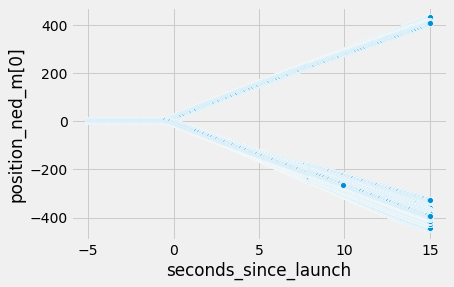

In [187]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["position_ned_m[0]"])

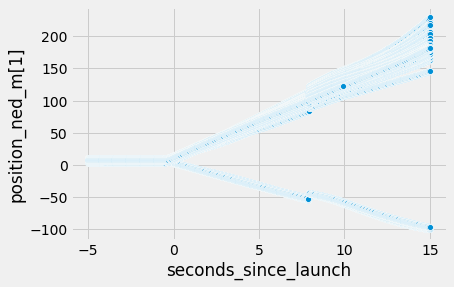

In [188]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["position_ned_m[1]"])

#### Let's visualize the position of the drone from the reference point (0,0) at the time of last data recording. 

In [44]:
temp_df = df[df.groupby("flight_No")["seconds_since_launch"].transform(max) == df['seconds_since_launch']]
temp_df.head()

,seconds_since_launch,position_ned_m[0],position_ned_m[1],position_ned_m[2],velocity_ned_mps[0],velocity_ned_mps[1],velocity_ned_mps[2],accel_body_mps2[0],accel_body_mps2[1],accel_body_mps2[2],orientation_rad[0],orientation_rad[1],orientation_rad[2],angular_rate_body_radps[0],angular_rate_body_radps[1],angular_rate_body_radps[2],position_sigma_ned_m[0],position_sigma_ned_m[1],position_sigma_ned_m[2],flight_No
1000,14.99538,-389.31625,176.80908,-76.73076,-23.909140,13.438327,-1.992613,1.469914,0.246911,-4.156568,-0.285183,0.068529,2.599779,-0.145041,-0.113501,-0.087676,0.129551,0.225514,0.296766,16951
2001,14.99540,-397.08936,180.99980,-77.16143,-24.965630,13.988238,-0.757300,1.745920,0.249279,-5.312444,-0.396258,0.071361,2.666603,-0.143309,-0.049896,-0.060866,0.440123,0.450459,0.468057,16952
3002,14.99546,-382.16550,172.13757,-75.26395,-22.717490,12.055452,-3.815254,1.048035,0.390775,-5.771955,-0.264105,0.154721,2.659648,-0.103265,-0.154996,-0.114805,0.544848,0.602897,0.531991,16954
4003,14.99553,-375.21335,168.74245,-74.25971,-22.479141,11.079210,-4.548569,1.929941,0.220415,-9.624934,-0.231785,0.194967,2.600351,-0.074000,-0.131669,-0.063767,0.361827,0.495776,0.341767,16955
5004,14.99544,-381.59552,172.78238,-74.60705,-23.471363,12.282152,-2.710729,1.615925,0.303682,-5.644479,-0.264978,0.158007,2.624602,-0.134525,-0.150615,-0.137181,0.019826,0.028119,0.067745,16957


(-600, 600)

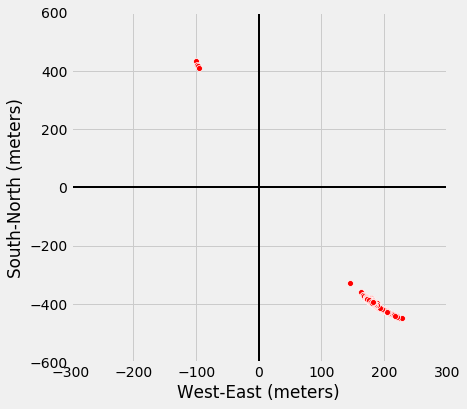

In [49]:
plt.figure(figsize=(6,6))
sns.scatterplot(y = temp_df["position_ned_m[0]"], x = temp_df["position_ned_m[1]"], color="red")
plt.plot([-300, 300], [0, 0], linewidth=2, color = "black")
plt.plot([0, 0], [-600, 600], linewidth=2, color = "black")
plt.xlabel("West-East (meters)")
plt.ylabel("South-North (meters)")
plt.xlim(-300,300)
plt.ylim(-600,600)

As we can see most of the drones launch in the South-East direction even they are used to serve western half of Rwanda. Let's visualize wind directions at the time of launches of all flights.

In [41]:
temp_df = df_summary[["wind_direction", "wind_magnitude"]]
temp_df["wind_direction"] = df_summary["wind_direction"].apply(lambda x: (360 + x) if x < 0 else x)

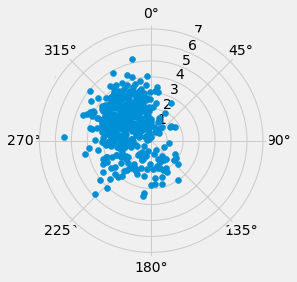

In [42]:
ax = plt.subplot(111, polar=True)
ax.scatter(x=[math.radians(x) for x in temp_df['wind_direction'].values], y=temp_df['wind_magnitude'].values)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

As we can see most of the time wind is in the north-west direction and drone takes off in the opposite direction of the wind.

Conventional wisdom may lead us to believe that taking off into the wind increases resistance, slowing the plane down while forcing it to burn more fuel for energy. However, there’s a good reason for this strategic decision.

Basically, taking off into the wind allows to achieve a higher altitude in less time, and with less speed.

#### Let's check the direction of wind for the cases of drone flight in the north-west direction.

In [50]:
North_West = temp_df[(temp_df["position_ned_m[0]"] > 0) & (temp_df["position_ned_m[1]"] < 0)]
North_East = temp_df[(temp_df["position_ned_m[0]"] > 0) & (temp_df["position_ned_m[1]"] > 0)]
South_West = temp_df[(temp_df["position_ned_m[0]"] < 0) & (temp_df["position_ned_m[1]"] < 0)]
South_Eest = temp_df[(temp_df["position_ned_m[0]"] < 0) & (temp_df["position_ned_m[1]"] > 0)]

In [51]:
print("Number of Flights in different directions-")
print("North_West:", North_West.shape[0])
print("North_East:", North_East.shape[0])
print("North_East:", North_East.shape[0])
print("South_Eest:", South_Eest.shape[0])

Number of Flights in different directions-
North_West: 4
North_East: 0
North_East: 0
South_Eest: 443


As we can see most of the flights are in the South-East directions and only 4 flights are in the North-West directions.

In [52]:
NW_flight = North_West.flight_No.values
NW_flight

array([17136, 17437, 17438, 17439], dtype=int64)

In [53]:
temp_df = df_summary[df_summary["flight_id"].isin(NW_flight)]

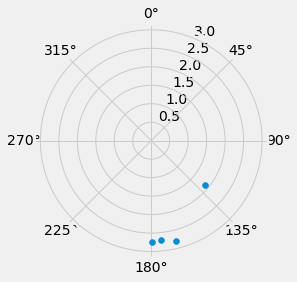

In [54]:
ax = plt.subplot(111, polar=True)
ax.scatter(x=[math.radians(x) for x in temp_df['wind_direction'].values], y=temp_df['wind_magnitude'].values)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

As we can see drone launch into the north-west direction when the wind direction is south-east.

### Drone's position from the ground

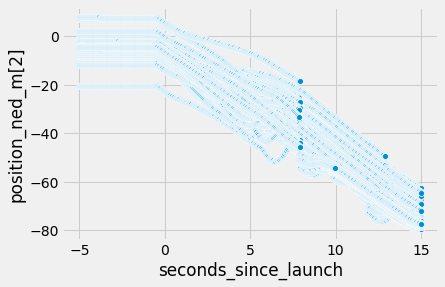

In [55]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["position_ned_m[2]"])

Let's see the drones' distance relative to the ground in the down direction at the time of last data recording

In [161]:
temp_df = df[df.groupby("flight_No")["seconds_since_launch"].transform(max) == df['seconds_since_launch']]

Text(0.5, 1.0, 'Distance of drones in the down direction')

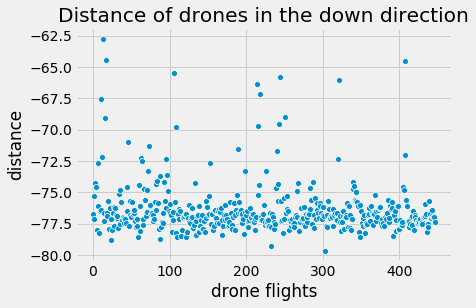

In [162]:
sns.scatterplot(x = range(len(temp_df)), y = temp_df["position_ned_m[2]"])
plt.xlabel("drone flights")
plt.ylabel("distance")
plt.title("Distance of drones in the down direction")

I want to find out which drone flights attain height less than 67.5 meters at the end of 15 seconds to find out if there is something wrong with these flights.

In [163]:
temp_df = temp_df[["flight_No", "position_ned_m[2]", "position_sigma_ned_m[2]"]][temp_df["position_ned_m[2]"] > -67.5]
temp_df

,flight_No,position_ned_m[2],position_sigma_ned_m[2]
14003,16984,-62.728863,0.426430
18002,16988,-64.410540,0.046151
107089,17162,-65.444820,0.057150
215173,17348,-66.388664,0.532903
219177,17352,-67.119225,0.020072
245199,17415,-65.787750,0.397616
322235,17574,-66.026180,0.489177
409314,17686,-64.477710,0.523911


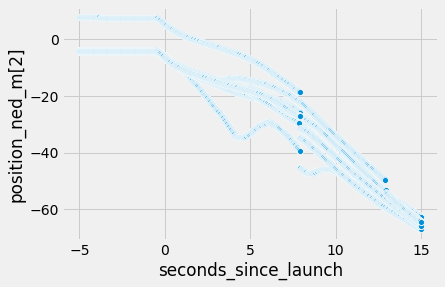

In [164]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(temp_df.flight_No)], y = df["position_ned_m[2]"][df.flight_No.isin(temp_df.flight_No)])

#### Let's see the drones' distance relative to the ground in the down direction 5 seconds before the launch

In [165]:
temp_df = df[df.groupby("flight_No")["seconds_since_launch"].transform(min) == df['seconds_since_launch']]

Text(0.5, 1.0, 'Distance of drones in the down direction')

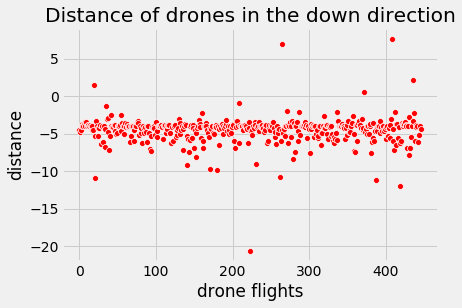

In [166]:
sns.scatterplot(x = range(len(temp_df)), y = temp_df["position_ned_m[2]"], color = "r")
plt.xlabel("drone flights")
plt.ylabel("distance")
plt.title("Distance of drones in the down direction")

Let's see the drones flights which have more or less starting distance than average in the downward direction.

In [167]:
temp_df = temp_df[["flight_No", "position_ned_m[2]", "position_sigma_ned_m[2]"]][(temp_df["position_ned_m[2]"] > 0) | (temp_df["position_ned_m[2]"] < -10)]
temp_df

,flight_No,position_ned_m[2],position_sigma_ned_m[2]
19004,16990,1.464444,1.009178
20005,16991,-10.908928,1.833301
223182,17359,-20.621550,3.200980
262178,17459,-10.847755,0.419615
265181,17462,6.959739,3.924224
372279,17639,0.525141,1.876473
387294,17660,-11.146791,2.396908
408314,17686,7.672992,0.415034
419325,17702,-11.959343,2.981081
435341,17726,2.210745,3.177178


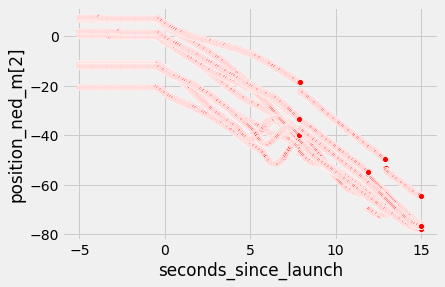

In [169]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(temp_df.flight_No)], y = df["position_ned_m[2]"][df.flight_No.isin(temp_df.flight_No)], color = 'r')

As we can see that initial position of the drone relative to the ground does not tell us effectively about the latest position of the drone.

I also noticed that in some of the flights between 5 and 10 seconds after the lauch of the drones, position relative to the ground suddenly decreases and then increases just like below. 

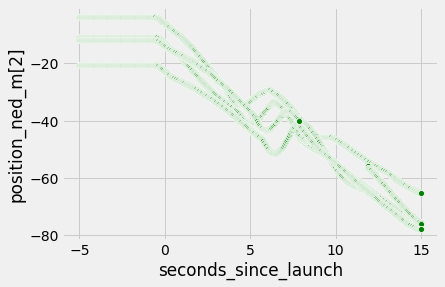

In [189]:
a = [16991, 17359, 17702, 17162] 
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(a)], y = df["position_ned_m[2]"][df.flight_No.isin(a)], color = 'green')

Let's see velocity plots of these flights.

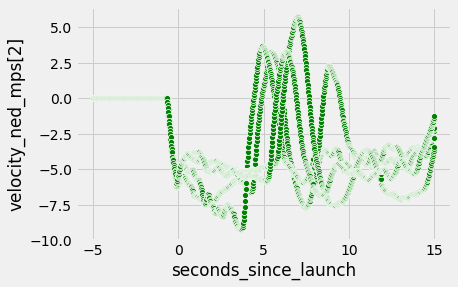

In [190]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(a)], y = df["velocity_ned_mps[2]"][df.flight_No.isin(a)], color = 'green')

As we can see there is a sudden increase in the velocity which is not desirable for the drone as it might lead to failure

### Velocities and Acceleration

Let's visualize velocities in north, east and down directions

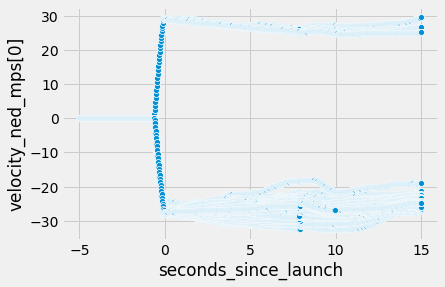

In [202]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["velocity_ned_mps[0]"])

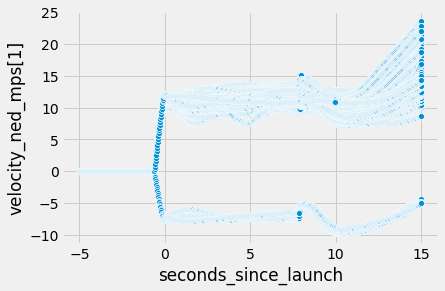

In [201]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["velocity_ned_mps[1]"])

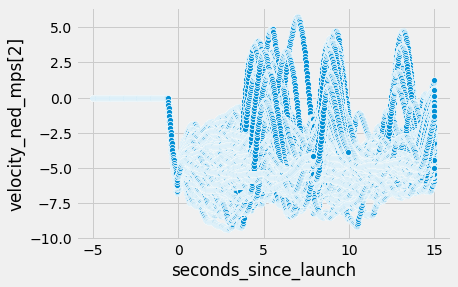

In [203]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["velocity_ned_mps[2]"])

As we can see the velocity values in the north and east direction do not change much unlike the velocity values in the down direction. The acceleration values in north and east direction should not change much and in down direction they should change considerably as acceleration is proportional to the change in velocities.

Let's visualize acceleration in north, east and down directions

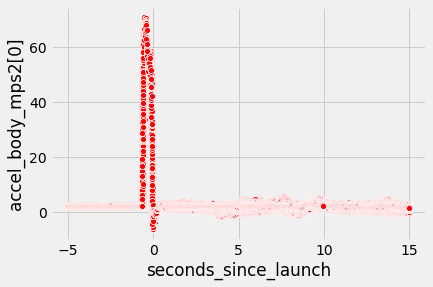

In [207]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["accel_body_mps2[0]"], color = 'r')

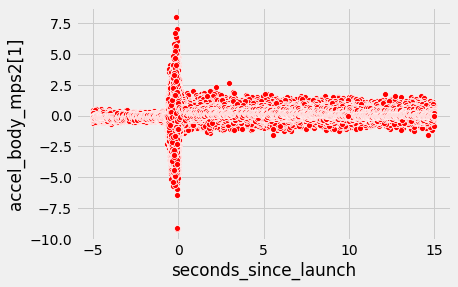

In [206]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["accel_body_mps2[1]"], color = 'r')

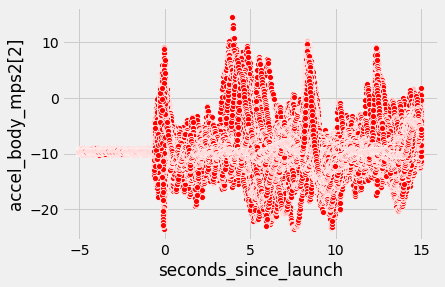

In [208]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["accel_body_mps2[2]"], color = 'r')

In the north and east direction initial acceleration is high and as soon as the drone achieve constant velocity, it becomes almost zero. But in the case of downward direction it keeps changing. Let's find out flights for which acceleration goes beyond the range of (-22, 10). 

In [224]:
flights = df["flight_No"][(df["accel_body_mps2[2]"] > 10) | (df["accel_body_mps2[2]"] < -22)].unique()

In [225]:
flights

array([16991, 17120, 17139, 17162, 17315, 17359, 17398, 17428, 17474,
       17515, 17623, 17635, 17660, 17734, 17737], dtype=int64)

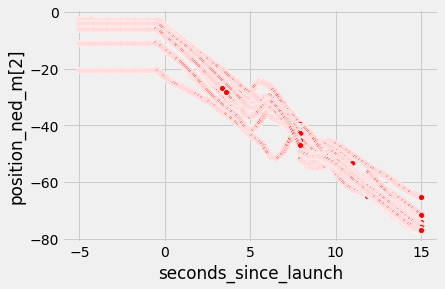

In [226]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(flights)], y = df["position_ned_m[2]"][df.flight_No.isin(flights)], color = 'red')

As we can see for these flights, there is sudden drop in the downward distance mostly between 5 to 10 seconds after the launch.

### Orientation

<img src="files/angles.png">

- orientation_rad[0] (radians) - Euler (Tait-Bryan) roll of the zip
- orientation_rad[1] (radians) - Euler (Tait-Bryan) pitch of the zip
- orientation_rad[2] (radians) - Euler (Tait-Bryan) yaw of the zip

Let's plot different orientations for all flights 

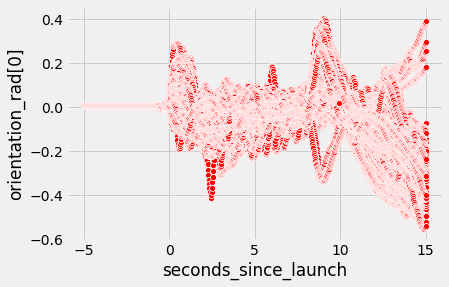

In [227]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["orientation_rad[0]"], color = 'r')

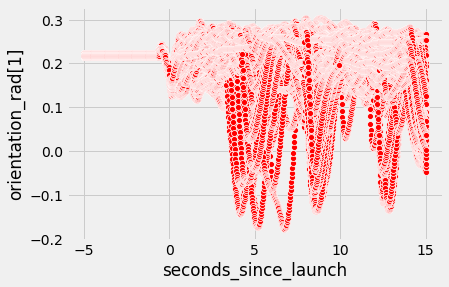

In [228]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["orientation_rad[1]"], color = 'r')

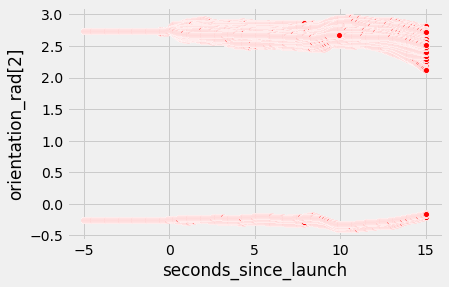

In [229]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["orientation_rad[2]"], color = 'r')

As we can see that pitch values changes a lot which helps the drone go upwards or downwards. The yaw remains almost same which makes sense as once you decide the direction of the drone, you do not have to change it much. The roll angle also changes much as greater the roll angle, easier for the drone to take the turn.

### Angular velocities

Let's plot angular velocities of all flights

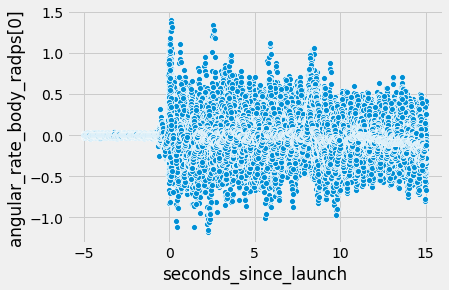

In [230]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["angular_rate_body_radps[0]"])

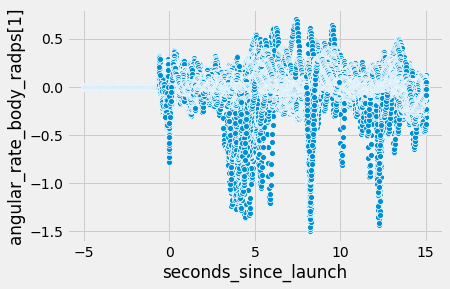

In [231]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["angular_rate_body_radps[1]"])

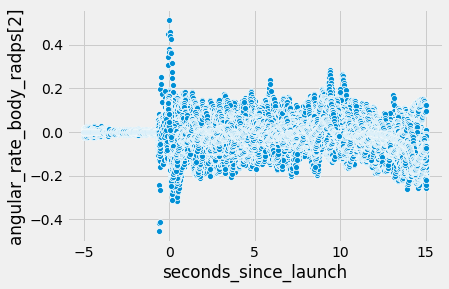

In [232]:
sns.scatterplot(x = df["seconds_since_launch"], y = df["angular_rate_body_radps[2]"])

The angular velocities in the east direction change much. Other than this we cannot retrieve much information from above graphs.

## Clustering

Above data analysis does not help us to find any patterns. Let's utilize machine learning algorithm to find the pattern.

### Dynamic Time Warping

Dynamic Time Warping (DTW) is a way to find similarity between two time series, while they could be shifted in time. Dynamic time warping finds the optimal non-linear alignment between two time series. The Euclidean distances between alignments are then much less susceptible to pessimistic similarity measurements due to distortion in the time axis. There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used.

My first choice to perform clustering was K-Means as I love that algorithm but we cannot use K-Means clustering for timeseries. DTW is not minimized by the mean; k-means may not converge and even if it converges it will not yield a very good result. The mean is an least-squares estimator on the coordinates. It minimizes variance, not arbitrary distances, and k-means is designed for minimizing variance, not arbitrary distances.

I am using DTW to make a distance matrix for all flights. My objective is to see if there is a similarity in recorded values of flights. It will help us to know if there is any pattern in the recorded values.

In [261]:
## I am clustering only first 50 timeseries as clustering requires a lot of time and computational power. 
## We can cluster all 447 flights in a similar manner 

In [262]:
#initializing matrix of size (50,50) 
distance_matrix = np.zeros((50,50))

In [263]:
feats = df.columns[1:16]
feats #required features for clustering

Index(['position_ned_m[0]', 'position_ned_m[1]', 'position_ned_m[2]',
       'velocity_ned_mps[0]', 'velocity_ned_mps[1]', 'velocity_ned_mps[2]',
       'accel_body_mps2[0]', 'accel_body_mps2[1]', 'accel_body_mps2[2]',
       'orientation_rad[0]', 'orientation_rad[1]', 'orientation_rad[2]',
       'angular_rate_body_radps[0]', 'angular_rate_body_radps[1]',
       'angular_rate_body_radps[2]'],
      dtype='object')

In [265]:
#creating different time series flight wise
df1 = {}
flights = df.flight_No.unique()
flights = flights[0:50]

standardScaler = StandardScaler()

for i in range(len(flights)):
    df1[i] = df[feats][df.flight_No == flights[i]]
    df1[i] = standardScaler.fit_transform(df1[i]) #scaling the values as DTW calculation will be faster

In [268]:
#finding DTW distances and saving them in the distance matrix
for i in range(0,50):
    for j in range(0,50):
        distance_matrix[i,j], _ = fastdtw(df1[i], df1[j], dist=euclidean)

In [321]:
np.save('C:\\Users\\archd\\OneDrive\\Desktop\\Zipline\\distance_matrix.npy', distance_matrix)

### Hiearachical Clustering

With the distance matrix we can cluster the flights using hierarchical clustering method.

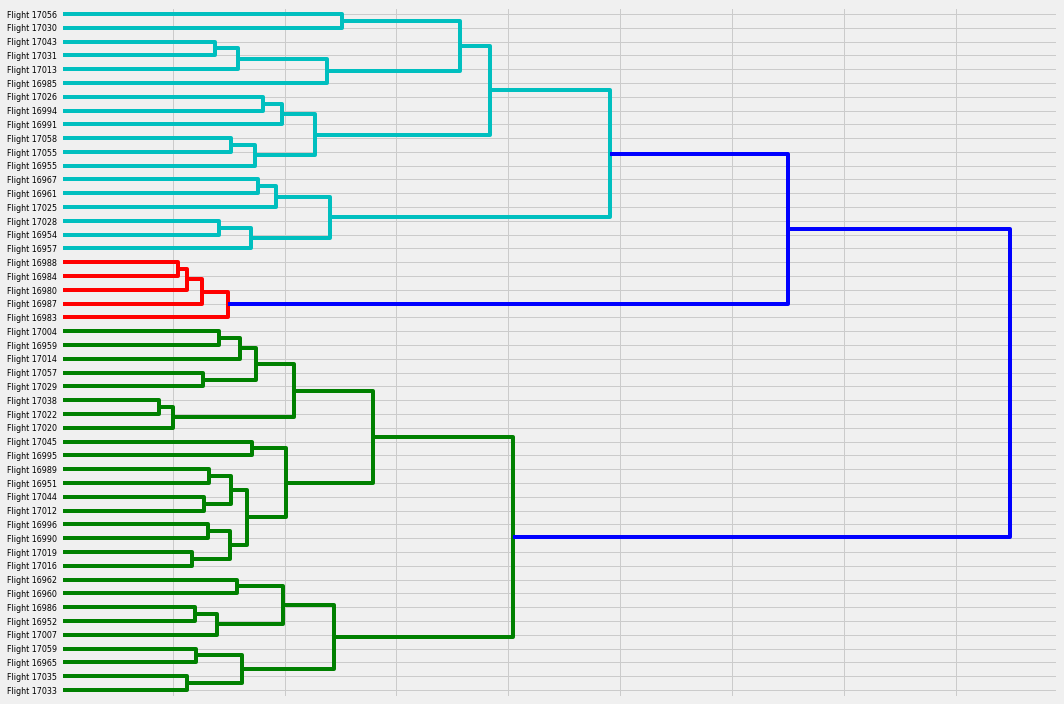

In [273]:
linkage_matrix = ward(distance_matrix) #ward's minimum variance method for bottom-up approach

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Flight {}".format(x) for x in flights]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#saving figure
plt.savefig('flight_clusters.png', dpi=200);

We can see from above dendogram that optimal number of clusters are 3.

In [305]:
clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
clusters

array([1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 2, 2, 2, 3, 1, 2, 2, 1, 1, 3, 3,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1,
       1, 3, 3, 1, 3, 1], dtype=int32)

Let's create a dataframe which contains flight and cluster number.

In [306]:
cluster_df = pd.DataFrame()
cluster_df["flight_No"] = flights
cluster_df["cluster"] = clusters

In [307]:
cluster_df.head()

,flight_No,cluster
0,16951,1
1,16952,1
2,16954,3
3,16955,3
4,16957,3


### Cluster Analysis

Let's see the velocity and downward distance for the flights in different clusters.

#### Cluster 1

In [303]:
f = cluster_df["flight_No"][cluster_df["cluster"] == 1]

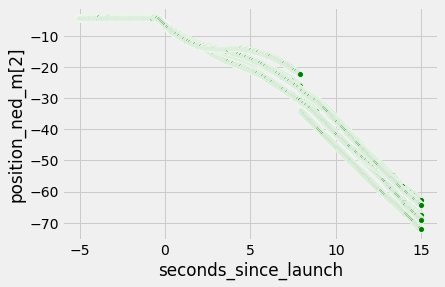

In [308]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(f)], y = df["position_ned_m[2]"][df.flight_No.isin(f)], color = 'green')

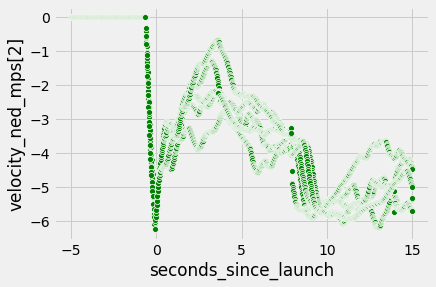

In [309]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(f)], y = df["velocity_ned_mps[2]"][df.flight_No.isin(f)], color = 'green')

#### Cluster 2

In [318]:
f = cluster_df["flight_No"][cluster_df["cluster"] == 2]

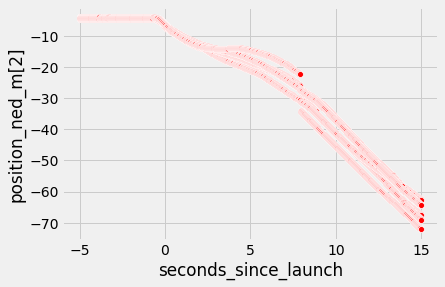

In [319]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(f)], y = df["position_ned_m[2]"][df.flight_No.isin(f)], color = 'red')

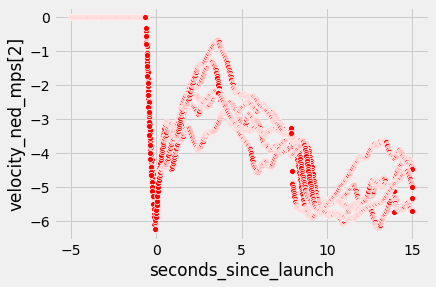

In [320]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(f)], y = df["velocity_ned_mps[2]"][df.flight_No.isin(f)], color = 'red')

#### Cluster 3

In [315]:
f = cluster_df["flight_No"][cluster_df["cluster"] == 3]

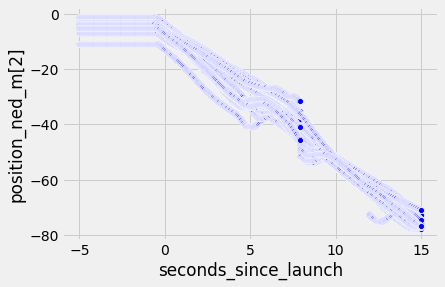

In [316]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(f)], y = df["position_ned_m[2]"][df.flight_No.isin(f)], color = 'blue')

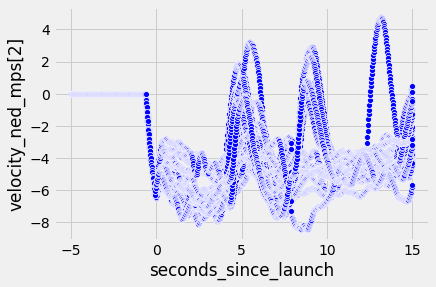

In [317]:
sns.scatterplot(x = df["seconds_since_launch"][df.flight_No.isin(f)], y = df["velocity_ned_mps[2]"][df.flight_No.isin(f)], color = 'blue')

## Conclusions

- Drones are launched in the opposite direction of the wind.
- Between 5 to 10 seconds after launch, many drones' elevation suddenly decreases and then increases and remains constant. This is also evident by sudden change in the velocity and acceleration values.
- Using DTW method we can accurately cluster the drone flights which can be used to study the performance of a drone. We can benchmark one timeseries and can compare flight data with it. If the dtw distance falls within the predefined safe range, we can say that drone works as intended. 